In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

In [2]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                    rotation_range=5,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

In [3]:
train_dataset  = train_datagen.flow_from_directory(directory = '../input/fer2013/train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 64)

Found 22968 images belonging to 7 classes.


In [4]:
valid_dataset = valid_datagen.flow_from_directory(directory = '../input/fer2013/train',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 64)

Found 5741 images belonging to 7 classes.


In [5]:
test_dataset = test_datagen.flow_from_directory(directory = '../input/fer2013/test',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

Found 7178 images belonging to 7 classes.


(224, 224, 3)
(1, 224, 224, 3)


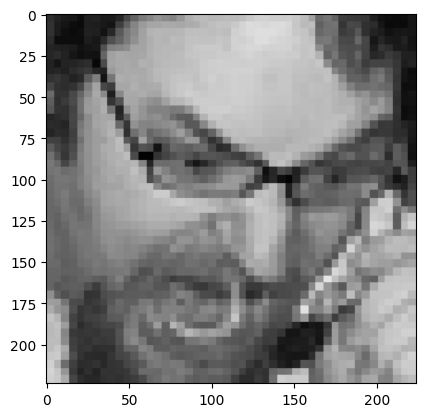

In [6]:
from tensorflow.keras.preprocessing import image
img = image.load_img("../input/fer2013/test/angry/PrivateTest_10131363.jpg",target_size=(224,224))
img = np.array(img)
plt.imshow(img)
print(img.shape)

img = np.expand_dims(img, axis=0)
print(img.shape)

In [7]:
from tensorflow.keras.models import load_model
print(img.shape)

(1, 224, 224, 3)


In [8]:
base_model = tf.keras.applications.ResNet50(input_shape=(224,224,3),include_top=False,weights="imagenet")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
for layer in base_model.layers[:-4]:
    layer.trainable=False

In [10]:
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

# number of possible label values
nb_classes = 7

# Initialising the CNN
model = Sequential()

# 1 - Convolution 
# extract relevant features from the images
model.add(base_model) #adding base model of ResNet50
model.add(BatchNormalization())  
model.add(Activation('relu'))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
# using these features to classify 
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(nb_classes, activation='softmax'))

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 7, 7, 2048)          │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 7, 7, 2048)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 7, 7, 2048)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 7, 7, 128)           │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 7, 7, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 7, 7, 512)           │         590,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 7, 7, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 7, 7, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 7, 7, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │              

 Total params: 39,665,415 (151.31 MB)

 Trainable params: 17,124,487 (65.32 MB)

 Non-trainable params: 22,540,928 (85.99 MB)

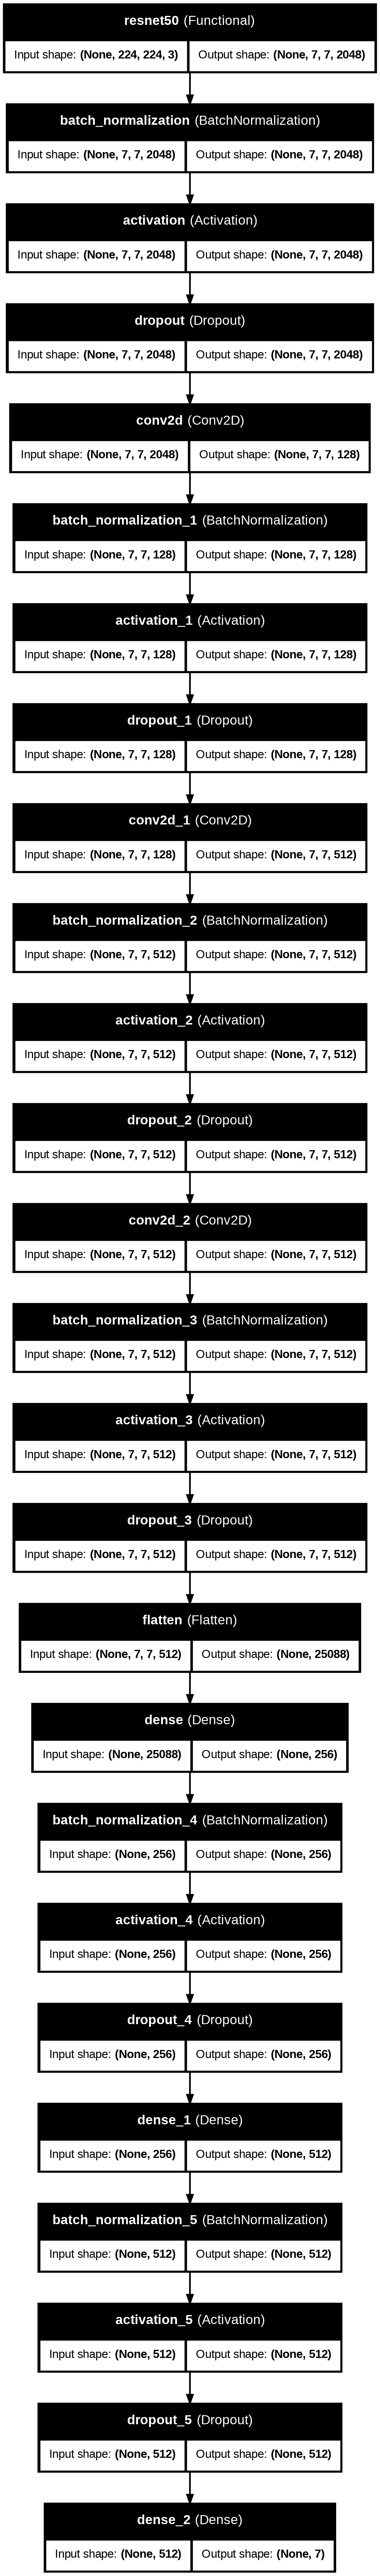

In [12]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='mymodel2.png', show_shapes=True,show_layer_names=True)
Image(filename='mymodel2.png') 

In [13]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [14]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precisi
      on'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [19]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)

mcp = ModelCheckpoint('resnet50_mymodel.h5')

es = EarlyStopping(verbose=1, patience=20)

ValueError: The filepath provided must end in `.keras` (Keras model format). Received: filepath=resnet50_mymodel.h5

In [15]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)

In [16]:
import tensorflow.keras.backend as K
from tensorflow.keras.applications.nasnet import NASNetLarge

history=model.fit(train_dataset,validation_data=valid_dataset,epochs = 20,verbose = 1)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


359/359 ━━━━━━━━━━━━━━━━━━━━ 387s 992ms/step - accuracy: 0.8435 - auc: 0.6073 - f1_score: 0.0576 - loss: 2.0665 - precision: 0.2146 - recall: 0.0352 - val_accuracy: 0.8567 - val_auc: 0.6508 - val_f1_score: 0.0017 - val_loss: 1.8226 - val_precision: 0.1923 - val_recall: 8.7093e-04
Epoch 2/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 277s 756ms/step - accuracy: 0.8550 - auc: 0.6402 - f1_score: 0.0089 - loss: 1.8666 - precision: 0.1896 - recall: 0.0046 - val_accuracy: 0.8549 - val_auc: 0.6547 - val_f1_score: 0.0064 - val_loss: 1.8700 - val_precision: 0.1462 - val_recall: 0.0033
Epoch 3/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 274s 749ms/step - accuracy: 0.8553 - auc: 0.6562 - f1_score: 0.0096 - loss: 1.8306 - precision: 0.2189 - recall: 0.0050 - val_accuracy: 0.8567 - val_auc: 0.6211 - val_f1_score: 0.0021 - val_loss: 1.9286 - val_precision: 0.2000 - val_recall: 0.0010
Epoch 4/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 273s 746ms/step - accuracy: 0.8559 - auc: 0.6591 - f1_score: 0.0118 - loss: 1.8225 - precision: 0.2884 

In [17]:
model.evaluate(test_dataset)


113/113 ━━━━━━━━━━━━━━━━━━━━ 47s 419ms/step - accuracy: 0.8542 - auc: 0.6144 - f1_score: 0.0969 - loss: 1.9838 - precision: 0.4211 - recall: 0.0552


[1.9622478485107422,
 0.8552122712135315,
 0.44652700424194336,
 0.0564224012196064,
 0.6205119490623474,
 0.10095074772834778]

In [34]:
# Save the model in HDF5 format in the output directory
model.save('/kaggle/working/mymodel.h5')



In [33]:
import tensorflow as tf

# Assuming 'model' is your trained model
model.save('/kaggle/working/emotion20E_model.h5')


In [ ]:
## plotting Results

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score']
              )

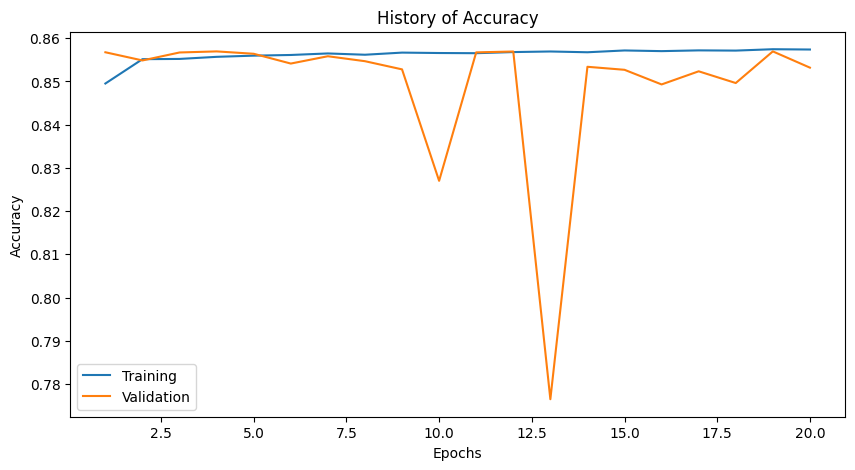

In [25]:
import matplotlib.pyplot as plt

def plot_accuracy(acc, val_acc):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(acc) + 1), acc)
    plt.plot(range(1, len(val_acc) + 1), val_acc)
    plt.title('History of Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Training', 'Validation'])
    plt.show()

# Call this in a separate cell
plot_accuracy(history.history['accuracy'], history.history['val_accuracy'])


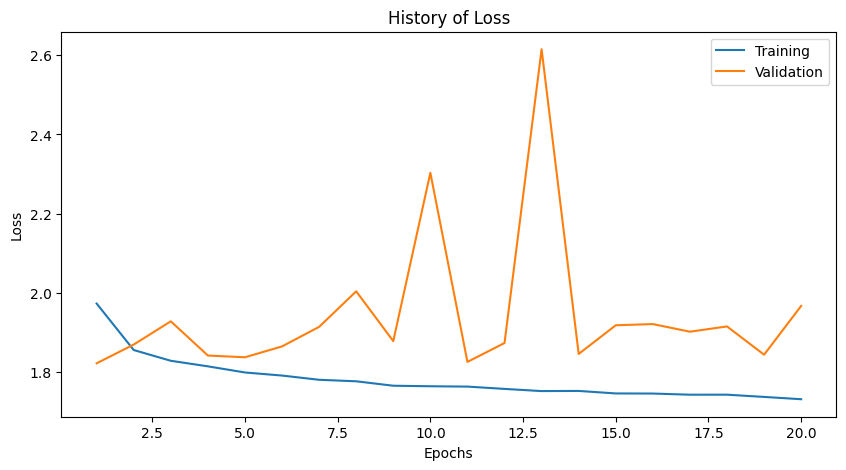

In [26]:
def plot_loss(loss, val_loss):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(loss) + 1), loss)
    plt.plot(range(1, len(val_loss) + 1), val_loss)
    plt.title('History of Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Training', 'Validation'])
    plt.show()

# Call this in a separate cell
plot_loss(history.history['loss'], history.history['val_loss'])


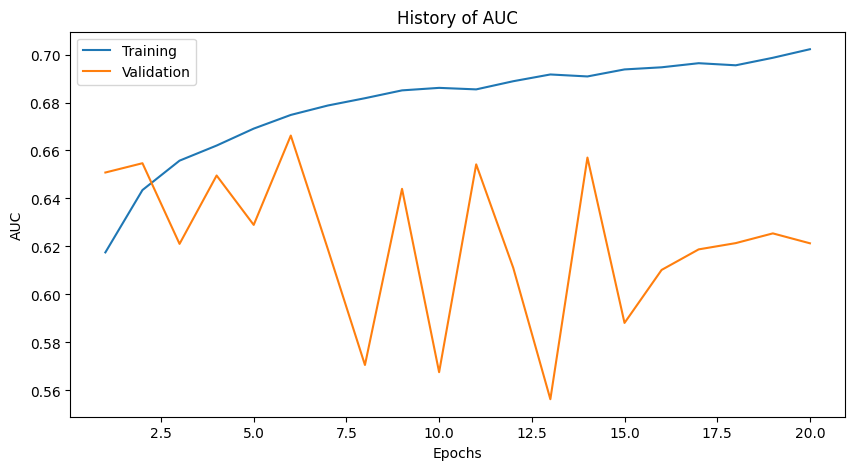

In [27]:
def plot_auc(auc, val_auc):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(auc) + 1), auc)
    plt.plot(range(1, len(val_auc) + 1), val_auc)
    plt.title('History of AUC')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend(['Training', 'Validation'])
    plt.show()

# Call this in a separate cell
plot_auc(history.history['auc'], history.history['val_auc'])


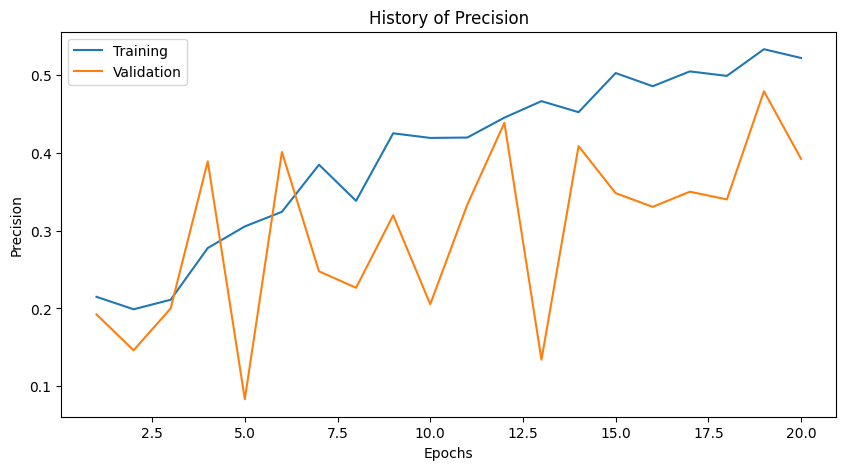

In [28]:
def plot_precision(precision, val_precision):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(precision) + 1), precision)
    plt.plot(range(1, len(val_precision) + 1), val_precision)
    plt.title('History of Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend(['Training', 'Validation'])
    plt.show()

# Call this in a separate cell
plot_precision(history.history['precision'], history.history['val_precision'])


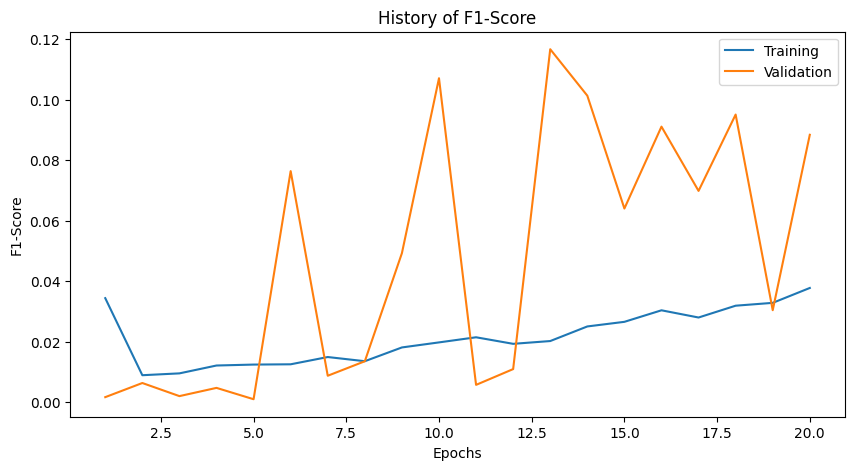

In [29]:
def plot_f1(f1, val_f1):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(f1) + 1), f1)
    plt.plot(range(1, len(val_f1) + 1), val_f1)
    plt.title('History of F1-Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1-Score')
    plt.legend(['Training', 'Validation'])
    plt.show()

# Call this in a separate cell
plot_f1(history.history['f1_score'], history.history['val_f1_score'])


In [30]:
y_pred = model.predict(test_dataset)

113/113 ━━━━━━━━━━━━━━━━━━━━ 23s 173ms/step


In [31]:
print(y_pred)

[[9.32807177e-02 6.29297877e-03 1.59526616e-01 ... 1.00474454e-01
  3.87546122e-02 2.30056539e-01]
 [1.33540839e-01 3.83713911e-03 2.02123404e-01 ... 8.62280279e-02
  4.47053052e-02 3.27521592e-01]
 [8.94099027e-02 1.63126725e-03 2.14635640e-01 ... 5.09086996e-02
  1.93694793e-02 5.15555322e-01]
 ...
 [1.28597096e-01 7.92153366e-03 1.51121780e-01 ... 1.16365127e-01
  6.79299831e-02 1.71626866e-01]
 [1.23694703e-01 3.61997029e-03 2.04911798e-01 ... 7.79161453e-02
  3.71664874e-02 3.35309058e-01]
 [4.45301048e-02 1.65616726e-07 5.47779560e-01 ... 8.13376997e-03
  1.03188464e-02 1.18791517e-02]]


In [32]:
test_acc = model.evaluate(test_dataset, verbose=2)
print(test_acc)

113/113 - 17s - 147ms/step - accuracy: 0.8552 - auc: 0.6205 - f1_score: 0.0997 - loss: 1.9622 - precision: 0.4465 - recall: 0.0564
[1.9622478485107422, 0.855212390422821, 0.44652700424194336, 0.0564224012196064, 0.6205119490623474, 0.09973128139972687]
